In [1]:
import logging, gensim, bz2
from gensim import corpora, models, similarities
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from bs4 import BeautifulSoup
import nltk
import re
from nltk.corpus import stopwords
import string
import itertools
exclude = set(string.punctuation)

### open test texts

In [9]:
soup = BeautifulSoup(open( unicode(u"all_source_texts/Re-Nutriv Script_Final Translation Template_deadline 20. april-en-da-T.mxliff")), 'lxml')
soup2 = BeautifulSoup(open(u"all_source_texts/Turkish_Basketball_Clubs_Evaluationprogramme15-16_Repucom_150612_Übersetzten-en-tr-T.mxliff"), 'lxml')

In [10]:
print "The text language source is", soup.file["source-language"]
print "The text language target is", soup.file["target-language"]

The text language source is en
The text language target is da


### what a file looks like

In [11]:
print soup.prettify()

<html>
 <body>
  <xliff m:level="1" m:version="2.0" version="1.2" xmlns="urn:oasis:names:tc:xliff:document:1.2" xmlns:m="http://www.memsource.com/mxlf/2.0">
   <file datatype="x-undefined" m:file-format="XLS" m:task-id="QD2UhI1HxBsq4axG0" original="Re-Nutriv Script_Final Translation Template_deadline 20. april.xlsx" source-language="en" target-language="da">
    <group id="0">
     <context-group>
      <context context-type="x-file-part">
       xl/sharedStrings.xml
      </context>
     </context-group>
     <trans-unit id="QD2UhI1HxBsq4axG0:0" m:confirmed="0" m:created-at="0" m:created-by="" m:gross-score="0.0" m:level-edited="false" m:locked="false" m:modified-at="0" m:modified-by="" m:para-id="2-tu1" m:score="0.0" m:trans-origin="null" xml:space="preserve">
      <source>
       Estée Lauder ID Script for Re-Nutriv Module {b&gt;| Final | 1/9/14&lt;b}
      </source>
      <target>
      </target>
      <alt-trans origin="machine-trans">
       <target>
       </target>
      </alt

### targeting the content

In [12]:
strings=[]
for string in soup.find_all("source"):
    strings.append(string.string)
    
strings2=[]
for string2 in soup2.find_all("source"):
    strings2.append(string2.string)

In [14]:

def tokenize(s):
# tokenize a string
    tokens=[]
    wnl = nltk.WordNetLemmatizer()
    tokens.append(nltk.word_tokenize(''.join(w for w in s)))
    tokens = [w for w in tokens[0] if not re.search('\.*[0-9]+\.*', w)]
    tokens = [w for w in tokens if w not in exclude]
    tokens = [w for w in tokens if len(w) > 2]
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    tokens = [wnl.lemmatize(t) for t in tokens]
    return tokens

def load_and_tokenize(path):
    try:
        soup = BeautifulSoup(open( path), 'lxml')
        strings=[]
        for string in soup.find_all("source"):
            strings.append(string.string)
        return tokenize( strings )
    except:
        print
        print "## CANNOT LOAD:" + path + " ##"
        return None

    


In [15]:
tokens = tokenize( strings )

tokens2 = tokenize( strings2 )

texts = [tokens] + [tokens2]

In [18]:
# path = "all_source_texts/Underbilag 3 3 Leverandørens generelle løsningsbeskrivelse - BI-en-da-T.mxliff"
# soup = BeautifulSoup(open( path.encode(sys.getfilesystemencoding())), 'lxml')

In [20]:
# import os
# import sys
# root = u"all_source_texts/"
# for filename in os.listdir(root):
#     filename = root + filename
#     print filename
#     open( filename.encode(sys.getfilesystemencoding()), "r")

---------

### load lda environement (locally)

In [21]:
lda = gensim.models.ldamodel.LdaModel.load('lda/wikipedia_lda', mmap='r')

In [22]:
for a in lda.print_topics(10):
    print a
    print "="*50

0.052*pb + 0.050*sb + 0.021*andhra + 0.017*mandal + 0.016*reddy + 0.014*telangana + 0.014*gf + 0.012*pradesh + 0.011*srinivas + 0.010*gd
0.029*stakes + 0.020*erigeron + 0.015*race + 0.014*horse + 0.013*ky + 0.011*chithra + 0.011*racing + 0.010*colt + 0.010*lengths + 0.010*jockey
0.018*medical + 0.014*hospital + 0.012*health + 0.012*medicine + 0.007*clinical + 0.006*patients + 0.006*research + 0.006*cancer + 0.006*care + 0.006*disease
0.012*babu + 0.009*kapoor + 0.007*sewanee + 0.007*hai + 0.007*puno + 0.007*hum + 0.006*zee + 0.006*rani + 0.006*yu + 0.006*zhao
0.020*canadian + 0.016*canada + 0.014*ontario + 0.011*newfoundland + 0.010*alberta + 0.010*toronto + 0.010*scotia + 0.009*nova + 0.006*ottawa + 0.006*edmonton
0.003*cast + 0.003*david + 0.003*james + 0.003*george + 0.003*robert + 0.003*michael + 0.003*directed + 0.002*william + 0.002*paul + 0.002*richard
0.012*basketball + 0.011*league + 0.010*coach + 0.009*football + 0.008*player + 0.007*conference + 0.007*tournament + 0.007*game

### indexing the tokens of the corpus

In [23]:
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

### running lda on corpus

In [24]:
corpus_lda = lda[corpus]

### displaying the major topics

In [25]:
a=[]
for doc in corpus_lda:
    a.append(sorted(doc, key=lambda item: (-1)*item[1]))

In [27]:
i = 0
for corpus in a:
    print "text %s" %i
    for s in corpus[:3]:
        print str(s) 
        print "\t" + unicode(lda.print_topic(int(s[0])))
    i += 1
    print

text 0
(77, 0.049072861238250658)
	0.004*television + 0.004*films + 0.004*festival + 0.004*tv + 0.004*actor + 0.004*awards + 0.004*directed + 0.004*show + 0.004*award + 0.003*episode
(97, 0.046087864215656173)
	0.008*research + 0.008*physics + 0.006*professor + 0.006*science + 0.005*chemistry + 0.005*engineering + 0.004*institute + 0.004*sciences + 0.003*technology + 0.003*laboratory
(43, 0.039444891115129596)
	0.044*stigmata + 0.035*repechage + 0.024*svg + 0.015*tracklisting + 0.012*și + 0.011*preliminaries + 0.009*flag + 0.008*ogol + 0.008*beatified + 0.007*whitish

text 1
(86, 0.092500004474433226)
	0.019*game + 0.006*games + 0.004*gameplay + 0.004*player + 0.004*video + 0.003*comics + 0.003*players + 0.003*comic + 0.003*manga + 0.003*playstation
(73, 0.05154561980774805)
	0.009*river + 0.007*mountain + 0.007*lake + 0.005*creek + 0.005*island + 0.004*water + 0.004*park + 0.003*region + 0.003*dam + 0.003*forest
(76, 0.047018140564034978)
	0.020*czech + 0.010*prague + 0.009*slovak + 0

In [28]:
print lda.print_topic(77)
print lda.print_topic(60)
print 
print lda.print_topic(57)
print lda.print_topic(78)

0.004*television + 0.004*films + 0.004*festival + 0.004*tv + 0.004*actor + 0.004*awards + 0.004*directed + 0.004*show + 0.004*award + 0.003*episode
0.014*gk + 0.012*vfl + 0.008*tba + 0.007*hee + 0.007*melbourne + 0.006*eun + 0.006*prem + 0.006*geelong + 0.005*victorian + 0.005*kyung

0.026*station + 0.024*railway + 0.009*airport + 0.008*train + 0.008*route + 0.007*road + 0.006*rail + 0.006*highway + 0.006*bus + 0.006*junction
0.009*fuscous + 0.005*ochreous + 0.005*hindwings + 0.003*plot + 0.003*story + 0.002*novel + 0.002*man + 0.002*suffused + 0.002*love + 0.002*you


In [29]:
d={}
for w in tokens:
    d[w]=tokens.count(w)
    
d2={}
for w in tokens2:
    d2[w]=tokens2.count(w)

In [30]:
remove=[]
for u,v in d.iteritems():
    if v==1:
        remove.append(u)
        
remove2=[]
for u,v in d2.iteritems():
    if v==1:
        remove2.append(u)

In [31]:
liste = [w for w in tokens if w not in remove]
liste2 = [w for w in tokens2 if w not in remove2]

### collocations

In [32]:
mots = ' '.join(liste)
mots2 = ' '.join(liste2)

In [33]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()
tokens = nltk.wordpunct_tokenize(mots)
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(4)
finder.nbest(bigram_measures.pmi, 20)

[(u'citrus', u'note'),
 (u'floral', u'scent'),
 (u'green', u'citrus'),
 (u'herbaceous', u'floral'),
 (u'jasmine', u'rose'),
 (u'lemon', u'grapefruit'),
 (u'muguet', u'jasmine'),
 (u'note', u'lemon'),
 (u'optimal', u'potency'),
 (u'preserve', u'optimal'),
 (u'recipe', u'kept'),
 (u'fresh', u'green'),
 (u'freshly', u'activated'),
 (u'potency', u'freshly'),
 (u'response', u'shown'),
 (u'secret', u'family'),
 (u'try', u'sorry'),
 (u'calm', u'soothe'),
 (u'consider', u'going'),
 (u'multiple', u'thing')]

In [34]:
bigram_measures2 = nltk.collocations.BigramAssocMeasures()
tokens2 = nltk.wordpunct_tokenize(mots2)
finder2 = BigramCollocationFinder.from_words(tokens2)
finder2.apply_freq_filter(4)
finder2.nbest(bigram_measures2.pmi, 20)

[(u'basketbol', u'ligi'),
 (u'right', u'holder'),
 (u'repucom', u'june'),
 (u'coverage', u'audience'),
 (u'sponsorship', u'evaluation'),
 (u'medium', u'evaluation'),
 (u'medium', u'value'),
 (u'sponsorship', u'value'),
 (u'value', u'medium')]

In [35]:
len(mots)

16533

In [36]:
len(mots2)

3472

- rules (constraint words)
- contract/law (specific)
- report
collocations
confusion matrix
tf-idf

# construct a projection matrix from a frequency space to a topic space

In [37]:
# translate the lda topics in dictionnaries
i = 0
topics = dict()
wordset = set()
for a in lda.print_topics(100):
    topic = dict()
#     print a
    pairs = a.split( ' + ')
    for p in pairs:
        pair = p.split('*')
#         print pair[0]
        value = float(pair[0])
        key = unicode(pair[1])
        topic[key] = value
        wordset.add(key)
    topics[i] = topic   
    i += 1
    


In [38]:
i = 0
word_dict = dict()
for w in wordset:
    word_dict[i] = w
    i += 1
    
    
word2int = dict()
for i in word_dict:
    word2int[word_dict[i]] = i

In [39]:
print len(wordset)

952


In [40]:
import math
#normalize topics
for t in topics:
    s = 0.0
    for v in topics[t].values():
        s+= v**2
    s = math.sqrt(s)
    inv_s = 1.0 / float(s)
    
    for key in topics[t]:
        topics[t][key] = topics[t][key] * inv_s

In [41]:
from scipy.sparse import *
from scipy import *
M = dok_matrix((len(wordset),len(topics)), dtype=float32)

print M.todense()

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [42]:
for i in range(0,len(wordset)):
    word = word_dict[i]
    for j in range(0, len(topics)):
        topic = topics[j]
        if word in topic.keys():
            M[ i,j] = topic[word]
        

## convert tokens to frequency space

In [43]:
def tokensToFrequencies( tokens ):
    x = dok_matrix((1, len(wordset)), dtype=float32)
    for t in tokens:
        if t in word2int.keys():
            x[0,word2int[t]] += 1          
    return x

In [44]:
# test
tokens = load_and_tokenize(unicode(u"source_texts/_WL-Contact_Technical_And_Functional_Proposal-1-en-de-T.mxliff"))
x = tokensToFrequencies(tokens)
print x
print word_dict[696]

  (0, 609)	2.0
  (0, 470)	4.0
  (0, 411)	3.0
  (0, 856)	4.0
  (0, 24)	9.0
  (0, 148)	10.0
  (0, 910)	3.0
  (0, 243)	4.0
  (0, 696)	121.0
  (0, 365)	5.0
  (0, 722)	1.0
  (0, 433)	4.0
  (0, 742)	1.0
  (0, 811)	6.0
  (0, 400)	1.0
  (0, 404)	8.0
  (0, 266)	1.0
  (0, 255)	4.0
  (0, 361)	28.0
  (0, 478)	14.0
  (0, 642)	1.0
  (0, 668)	8.0
  (0, 123)	1.0
  (0, 672)	4.0
  (0, 405)	1.0
  :	:
  (0, 136)	10.0
  (0, 92)	1.0
  (0, 385)	27.0
  (0, 392)	14.0
  (0, 96)	24.0
  (0, 463)	61.0
  (0, 692)	7.0
  (0, 360)	1.0
  (0, 686)	16.0
  (0, 19)	11.0
  (0, 628)	75.0
  (0, 551)	1.0
  (0, 876)	7.0
  (0, 465)	1.0
  (0, 743)	3.0
  (0, 459)	1.0
  (0, 869)	1.0
  (0, 799)	23.0
  (0, 68)	7.0
  (0, 265)	1.0
  (0, 803)	1.0
  (0, 564)	20.0
  (0, 403)	4.0
  (0, 247)	16.0
  (0, 60)	2.0
user


# convert frequency vector to the topic space

In [47]:
def getSemanticVector( path ):
    tokens = load_and_tokenize(path)
    if tokens == None:
        print " in getSemanticVector: no tokens"
        return None
    else:
        return tokensToFrequencies( tokens ) * M


def getClosestTopic(v , topic_to_display = -1):
    if v != None:
        i_max = 0
        m = 0
        results = dict()
        for i in range(0,len(topics)):
            results[i] = v[0,i]  
        k = 1
        if topic_to_display > 0:
            printResults_closestTopics( results, topic_to_display)

        return results
    else:
        return None

def printResults_closestTopics( results, n):
    if results != None:
        k = 1
        for i in sorted(results.items(), key=lambda x: x[1])[::-1][:n]:
            print str(k) + ": "  + str(topics[i[0]].keys())
            k += 1
            print

In [48]:
results = getClosestTopic( getSemanticVector( unicode(u"source_texts/_WL-Contact_Technical_And_Functional_Proposal-1-en-de-T.mxliff") ) )

In [49]:
print printResults_closestTopics(results, 3)

print results

1: [u'web', u'users', u'mobile', u'app', u'system', u'taluka', u'user', u'android', u'data', u'software']

2: [u'development', u'management', u'business', u'students', u'research', u'founded', u'institute', u'services', u'education', u'technology']

3: [u'television', u'discal', u'tv', u'broadcasting', u'station', u'radio', u'news', u'fm', u'channel', u'suffusion']

None
{0: 1.8829726, 1: 1.343742, 2: 10.392506, 3: 0.0, 4: 0.78321779, 5: 0.0, 6: 0.0, 7: 0.51851851, 8: 0.82112849, 9: 0.19824558, 10: 1.6329932, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.5647825, 15: 0.0, 16: 1.5091984, 17: 0.0, 18: 3.5395093, 19: 0.0, 20: 6.2225528, 21: 0.0, 22: 0.0, 23: 0.14897926, 24: 1.7060845, 25: 59.896564, 26: 0.0, 27: 0.0, 28: 0.0, 29: 3.0127451, 30: 0.0, 31: 0.0, 32: 3.1782243, 33: 2.424871, 34: 7.3886313, 35: 16.162758, 36: 6.2868309, 37: 0.0, 38: 5.706265, 39: 3.4827106, 40: 0.18632104, 41: 0.54886723, 42: 0.0, 43: 0.13438825, 44: 22.152937, 45: 0.0, 46: 0.0, 47: 0.0, 48: 0.65028417, 49: 1.4070029, 50: 0

# topic distribution

In [50]:
import os
import sys
filelist = []
root = u"all_source_texts/"
for filename in os.listdir(root):
    filename = root + filename
    print filename
    filelist .append(filename.encode(sys.getfilesystemencoding()))
    
#     import glob
# filelist = glob.glob('all_source_texts/*.mxliff')
    
for f in filelist:
    print f

all_source_texts/13_pd_spec_fortigel_b-en-ru-T.mxliff
all_source_texts/140702_swatch_SOM_A4_preview-en-fr-T.mxliff
all_source_texts/1410-0002 DEEP SEA MONSTER Press Outs-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 FAST FLESH EATERS pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 fearsome fighters Press Outs-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 Giants of the Jurassic pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 Killers of Cretaceous pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 mega meateater pressouts -en-fr_ca-CR.mxliff
all_source_texts/1814_Imbox Imagebrochure_REN 2_2015-8-20-en-de-T.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN COVER-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 1-8-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 25-40-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 41-48-en-fr_ca-CR.mxliff


In [51]:
score_per_topic = dict()
for i in topics:
    score_per_topic[i] = 0.0
    
print "%s files" %len(filelist)
i = 0
all_results = dict()
for f in filelist:
    print i,
    results = getClosestTopic( getSemanticVector( f ))
    all_results[f] = results
    if results != None:
        for key in results:
            score_per_topic[key] += results[key]
    i += 1

159 files
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158


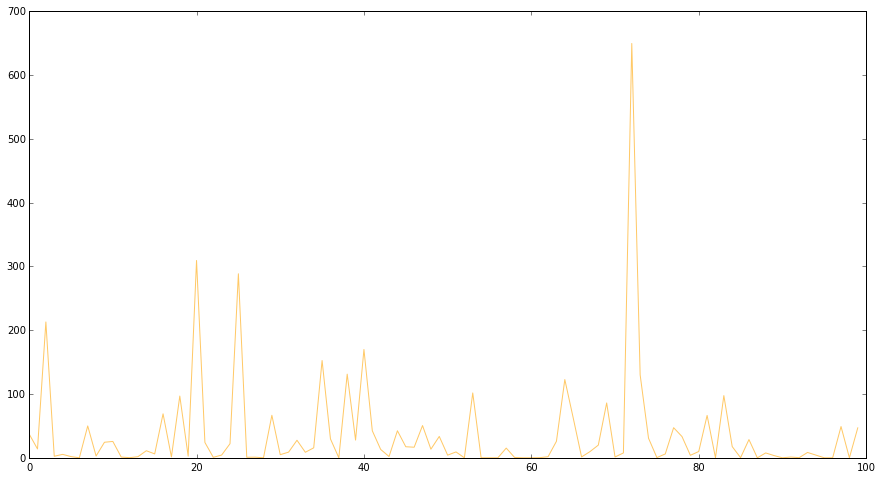

In [52]:
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)

plt.plot(score_per_topic.keys(), score_per_topic.values(),'orange', alpha = 0.6)

# find labels

In [54]:
import operator
topics_labels = dict()

print "unrecognized labels:"
for i in topics: 
    x = topics[i]
    sorted_x = sorted(x.items(), key=operator.itemgetter(1))[::-1]
    s = ''
    for e in sorted_x:
        try:
            s+= ' ' + str( e[0].decode('utf-8') )
        except:
            print e[0]
#     print s
    
    topics_labels[i] = s

unrecognized labels:
fútbol
série
martín
josé
maría
gijón
și
são
lycée
théâtre
méxico


In [55]:
score_per_topic_sorted =  sorted(score_per_topic.items(), key=operator.itemgetter(1))[::-1]

X = []
Y = []
k = 0

print "most common topics (score & labels)"
for e in score_per_topic_sorted:
    i = e[0]
    Y.append(e[1])
    X.append(topics_labels[i])
    if k < 10:
        print str(e[1]) + "\t"+ str(topics_labels[i])
    k+=1

most common topics (score & labels)
649.738262713	 software data app users taluka mobile android user system web
309.438365415	 german der von und berlin germany die hans vienna austrian
288.568334728	 business education students management technology services institute founded research development
213.014088839	 porch engine fascia rear design aircraft power timber mw portico
169.893714204	 medical hospital medicine health clinical care patients research disease cancer
152.561792374	 french la jean france paris le du des les pierre
131.186458528	 party election minister council elected elections political president cultivators votes
130.048723683	 river lake mountain island creek water park dam forest region
122.699321017	 species mm genus grey brown dark described pale costa gelechiidae
101.722805798	 ship navy ships naval boat hms fleet class vessel submarine


In [58]:
# run the cell below before this one
import plotly.tools as tls
tls.embed(url)

In [57]:
import plotly.plotly as py
py.sign_in('vlievin', '3epodkv7pd')
import matplotlib.pyplot as plt
import numpy as np
import plotly.plotly as py
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
import plotly.plotly as py
from plotly.graph_objs import *

trace1 = Bar(
        x= X,
        y= Y
    )
data = Data([trace1])

url = py.plot(data)



In [85]:
print "most common topics (score & labels)"
for e in score_per_topic_sorted:
    i = e[0]
    Y.append(e[1])
    X.append(topics_labels[i])
    print str(i) + ": " + str(e[1]) + "\t"+ str(topics_labels[i])

most common topics (score & labels)
72: 649.738262713	 software data app users taluka mobile android user system web
20: 309.438365415	 german der von und berlin germany die hans vienna austrian
25: 288.568334728	 business education students management technology services institute founded research development
2: 213.014088839	 porch engine fascia rear design aircraft power timber mw portico
40: 169.893714204	 medical hospital medicine health clinical care patients research disease cancer
35: 152.561792374	 french la jean france paris le du des les pierre
38: 131.186458528	 party election minister council elected elections political president cultivators votes
73: 130.048723683	 river lake mountain island creek water park dam forest region
64: 122.699321017	 species mm genus grey brown dark described pale costa gelechiidae
53: 101.722805798	 ship navy ships naval boat hms fleet class vessel submarine
83: 97.5347474217	 crambidae loaf restaurant food chef restaurants sprinkled cuisine l

# similarity

In [59]:
semantic_vectors = dict()
for f in filelist:
    print f
    v = getSemanticVector( f )
    if len(v.data):
        semantic_vectors[f] = v
print " ------------------------------- "
# test
for s in semantic_vectors.values():
    print list(s[0,:])

all_source_texts/13_pd_spec_fortigel_b-en-ru-T.mxliff
all_source_texts/140702_swatch_SOM_A4_preview-en-fr-T.mxliff
all_source_texts/1410-0002 DEEP SEA MONSTER Press Outs-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 FAST FLESH EATERS pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 fearsome fighters Press Outs-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 Giants of the Jurassic pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 Killers of Cretaceous pressouts-en-fr_ca-CR.mxliff
all_source_texts/1410-0002 mega meateater pressouts -en-fr_ca-CR.mxliff
all_source_texts/1814_Imbox Imagebrochure_REN 2_2015-8-20-en-de-T.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN COVER-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 1-8-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 25-40-en-fr_ca-CR.mxliff
all_source_texts/1844 0010 S&A MY BIG BOOK OF STICKER FUN INTERIORS 41-48-en-fr_ca-CR.mxliff


In [60]:
def norm(v):
    s = 0
    for d in v.data:
        s+= d**2
    return sqrt(s)

def similarity( a, b):
    # cosine similarity
    p = (a.dot(b.transpose()) / (norm(a) * norm(b))).data
    if len(p):
        return p[0]


def closestFile( path ):
    u = getSemanticVector(path)
    similarities = dict()
    for s in semantic_vectors:
        similarities[s] = similarity(semantic_vectors[s],u)
        
    k = 1
    for i in sorted(similarities.items(), key=lambda x: x[1])[::-1][:10]:
        print str(k) + "  |  "  + str(i)
        k += 1

In [61]:
path = u"all_source_texts/"+"ENG - Basic Modules_Eating Habits_V59-MH-en-ko-T.mxliff"
closestFile(path)

1  |  ('all_source_texts/ENG - Basic Modules_Eating Habits_V59-MH-en-ko-T.mxliff', 0.99999990964651952)
2  |  ('all_source_texts/quality_dossier_fortigel_b_rev_6_2014 (1)-en-ru-T.mxliff', 0.88239966847434059)
3  |  ('all_source_texts/Inspiration - tiny gardens_DA_en-GB-en-it-T.mxliff', 0.86226240200644388)
4  |  ('all_source_texts/ENG - Basic Modules_Food Intake_QNA_V59-MH-en-ko-T.mxliff', 0.85192681176509555)
5  |  ('all_source_texts/ENG - Ziele_V59-MH-en-ko-T.mxliff', 0.80948561694311827)
6  |  ('all_source_texts/ENG - Triage-Questions_V59-MH-en-ko-T.mxliff', 0.72801851581685351)
7  |  ('all_source_texts/Hvad er mikrogr\xf8nt_en-GB-en-it-T.mxliff', 0.72129101701576304)
8  |  ('all_source_texts/De 12 varianter - blyanten_en-GB-en-it-T.mxliff', 0.5485315671811285)
9  |  ('all_source_texts/900 GB_Company Profile_2015-en-ru-T.mxliff', 0.52348572222375156)
10  |  ('all_source_texts/Personlig s\xe6tning_en-GB-en-it-T.mxliff', 0.5082329616750243)


# vizualise a topic - WordCloud

In [81]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def WordCloudTopic( i ):
    # Generate a word cloud image
    wc = WordCloud(background_color="white", max_words=2000,
               max_font_size=40, random_state=42)
    wordcloud = wc.generate_from_frequencies(topics[i].items())    
    plt.imshow(wordcloud)
    plt.axis("off")

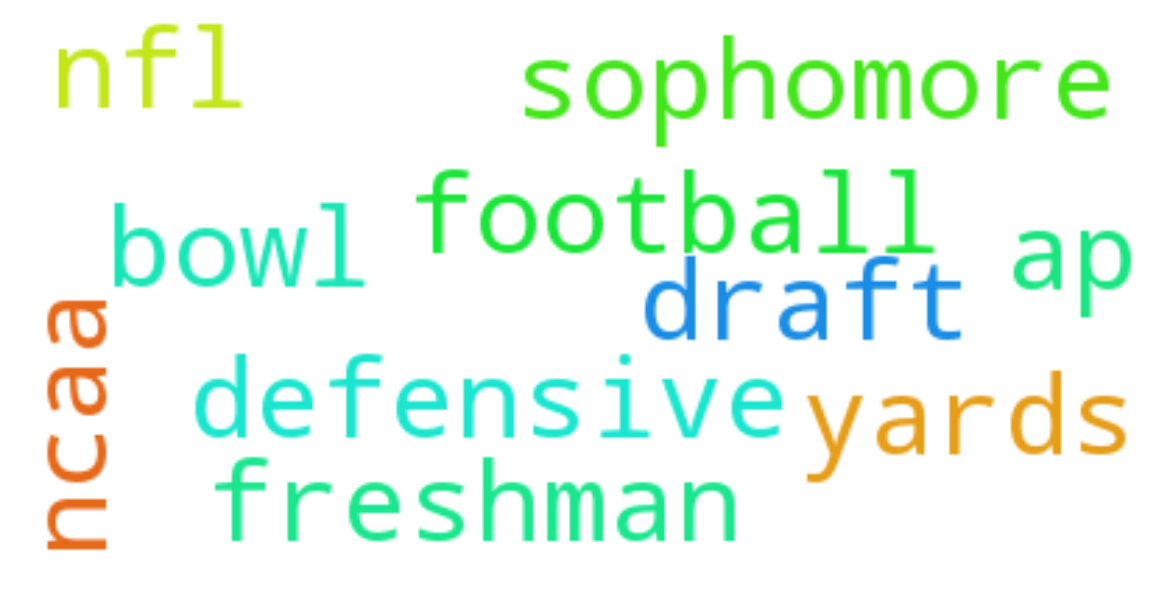

In [83]:
WordCloudTopic( 1 )